# **Libraries**

In [ ]:
# Install dependencies (if not installed yet)
!pip install Pillow torch torchvision evaluate tf-keras opencv-python

import os
import glob
import torch
import cv2
import zipfile
import numpy as np
from PIL import Image, ImageOps
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, Trainer, TrainingArguments, ViTImageProcessor, AutoConfig, TrainerCallback

# Disable WandB if not needed
os.environ["WANDB_DISABLED"] = "true"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Uploading and Extracting the **Dataset**

In [ ]:
# HANDLE ZIP FILE EXTRACTION
zip_path = '/content/preprocessed2_dataset.zip'  # Path to your ZIP file
extracted_path = '/content/preprocessed2_dataset'  # Extraction directory

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Dataset extracted to: {extracted_path}")

# Define paths to train and validation folders
dataset_dir = os.path.join(extracted_path, "preprocessed2_dataset")  # Dataset folder inside extracted ZIP
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")


Dataset extracted to: /content/preprocessed2_dataset


# **Configuration**

In [ ]:
# Configuration
IMG_SIZE = 56
PATCH_SIZE = 8
MODEL_NAME = 'google/vit-base-patch16-224'
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
class PreprocessedDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        # Use os.walk to recursively find all .jpg images
        self.image_paths = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root, file))

        # Check if any images were found
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {root_dir}. Check the directory path.")
        self.class_names = sorted(os.listdir(root_dir))  # Class folder names
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        self.transform = transform

        # Define augmentations
        if augment:
            self.augmentations = transforms.Compose([
                transforms.RandomRotation(degrees=15, fill=255),
                transforms.RandomAffine(degrees=0, shear=10, fill=255),
                transforms.RandomAffine(
                    degrees=0,
                    scale=(0.8, 1.2),
                    translate=(0.02, 0.02),
                    fill=255
                ),
            ])
        else:
            self.augmentations = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_name = os.path.basename(os.path.dirname(image_path))  # Extract class folder name
        label = self.class_to_idx[label_name]  # Convert class name to index

        # Load image and apply transforms
        image = Image.open(image_path).convert("RGB")  # Load as RGB

        # Apply augmentations
        if self.augmentations:
            image = self.augmentations(image)

        # Apply additional preprocessing transforms
        if self.transform:
            image = self.transform(image)

        return {"pixel_values": image, "labels": torch.tensor(label)}

# Define Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


In [ ]:

train_dataset = PreprocessedDataset(train_dir, transform=transform, augment=True)
val_dataset = PreprocessedDataset(val_dir, transform=transform, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")

Loaded 31500 training images and 13500 validation images.


In [ ]:
# Load and modify model configuration
config = AutoConfig.from_pretrained(MODEL_NAME)
config.image_size = IMG_SIZE
config.patch_size = PATCH_SIZE
config.num_labels = len(train_dataset.class_names)  # Number of classes

# Initialize model with modified configuration
model = ViTForImageClassification(config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

In [ ]:
# Define Image Processor
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
processor.size = {"height": IMG_SIZE, "width": IMG_SIZE}

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
import logging

logging.basicConfig(filename='training.log', level=logging.INFO)
logger = logging.getLogger()

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=3e-5,
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_dir="./logs",
    log_level="error",
    save_total_limit=2,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

In [ ]:
from transformers import TrainerCallback

class TrainingAccuracyCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model=None, tokenizer=None, train_dataloader=None, **kwargs):
        if train_dataloader is not None:
            correct = 0
            total = 0
            model.eval()  # Set model to evaluation mode
            for batch in train_dataloader:
                inputs = batch["pixel_values"].to(model.device)
                labels = batch["labels"].to(model.device)

                with torch.no_grad():
                    outputs = model(inputs).logits
                    predictions = torch.argmax(outputs, dim=1)
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

            train_accuracy = correct / total
            print(f"Training Accuracy: {train_accuracy:.4f}")

            # Save the training accuracy in logs
            state.log_history.append({"epoch": state.epoch, "train_accuracy": train_accuracy})


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[TrainingAccuracyCallback()],  # Add this line
)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.541600,1.715175,0.460222
2,1.497400,0.998684,0.682000
3,0.934900,0.660078,0.791185
4,0.678500,0.614978,0.800074
5,0.534200,0.364659,0.882519
6,0.430000,0.341550,0.891778
7,0.363200,0.290541,0.902815
8,0.306400,0.254079,0.921556
9,0.263600,0.219276,0.927852
10,0.224200,0.169427,0.944148


Training Accuracy: 0.4266
Training Accuracy: 0.6239
Training Accuracy: 0.7417
Training Accuracy: 0.7731
Training Accuracy: 0.8565
Training Accuracy: 0.8750
Training Accuracy: 0.8899
Training Accuracy: 0.9045
Training Accuracy: 0.9160
Training Accuracy: 0.9359
Training Accuracy: 0.9461
Training Accuracy: 0.9567
Training Accuracy: 0.9622
Training Accuracy: 0.9674
Training Accuracy: 0.9716


TrainOutput(global_step=14775, training_loss=0.5647290230120096, metrics={'train_runtime': 2926.751, 'train_samples_per_second': 161.442, 'train_steps_per_second': 5.048, 'total_flos': 2.27450744702496e+18, 'train_loss': 0.5647290230120096, 'epoch': 15.0})

In [ ]:
# Save the model state_dict manually
torch.save(model.state_dict(), "./trained_vit_model_state_dict.pth")

# Save the model configuration
model.config.to_json_file("./trained_vit_model_config.json")

# Save the entire model (including architecture and weights) with PyTorch
torch.save(model, './trained_vit_model.pth')

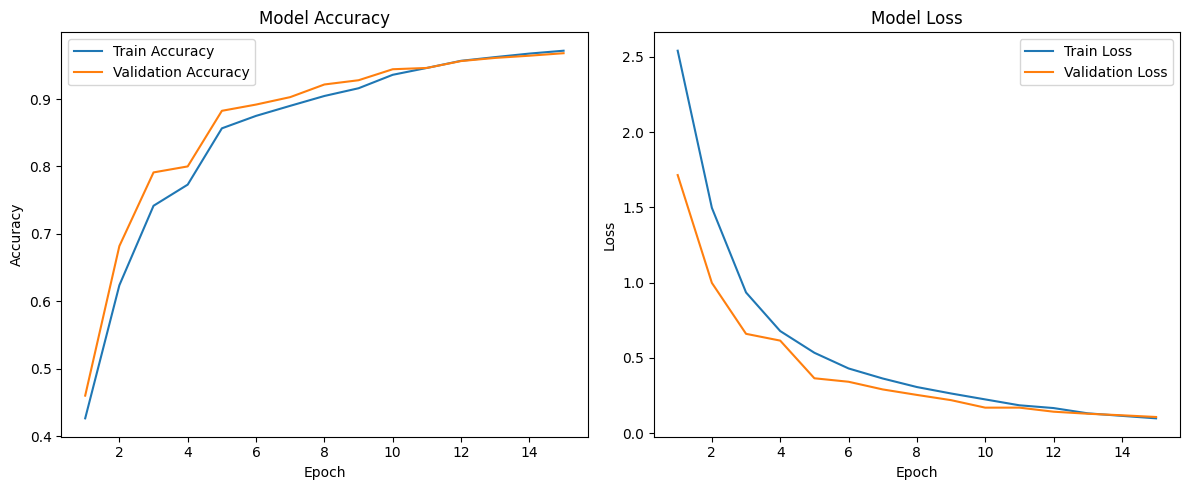

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for log in trainer.state.log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        epochs.append(log["epoch"])

    if "eval_loss" in log:
        val_losses.append(log["eval_loss"])

    if "eval_accuracy" in log:
        val_accuracies.append(log["eval_accuracy"])

    if "train_accuracy" in log:
        train_accuracies.append(log["train_accuracy"])

# Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
axes[0].plot(epochs, train_accuracies, label="Train Accuracy")
axes[0].plot(epochs, val_accuracies, label="Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].legend()

# Plot Loss
axes[1].plot(epochs, train_losses, label="Train Loss")
axes[1].plot(epochs, val_losses, label="Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Model Loss")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()
